# Human Activity Recognition in Videos using Keras (CNN + NCP)



## Some basics

Video Classification? 2 ways

**Single frame CNN classification system**
1. Split video into images, pass each image through an image classifier to get prediction per frame. Predict most common prediction as answer.
2. To improve upon this we can average across prediction probabilities. In most prediction networks, at the end we have a softmax layer which outputs prediction probabilities. So, if we average across class probabilities of all the frames. Then we have a more robust prediction.

Although this approach may work well, but it can run into problems because it doesn't take into account the temporal nature of video. How? Because in each frame we consider the spatial information, i.e. where the objects are location in the frame. But we disragard the temporal information if we just average across the probabilities. **Hence temporal information is very important**.

I have implemented video classification previously using 2 methods:
1. ConvLSTM
2. LRCN

Now, I will use the third method NCP.


## Outline

- Step 1: Download and visualize the data with its labels.
- Step 2: Preprocess the dataset
- Step 3: Split the data into train and test set
- Step 4: Implement the NCP approach
  - Step 4.1: Construct the model
  - Step 4.2: Compile and train the model
  - Step 4.3: Plot model's loss and accuracy curves
- Step 7: Test model on youtube videos

## Code

### Importing and installing the libraries

In [52]:
# Discard the output of this cell
%%capture

# install the required libraries
!pip install pafy youtube_dl moviepy

In [8]:
# import the required libraries as you require
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import datetime as dt
import pafy
import math

from moviepy.editor import *
%matplotlib inline

# from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

from collections import deque

In [3]:
# set up numpy, python and tensorflow seeds to get consistent results on every execution
seed_constant = 27
np.random.seed(seed_constant)                # numpy seed
random.seed(seed_constant)                   # python seed
tf.random.set_seed(seed_constant)            # tensorflow seed

### Step 1: Download and visualize the data with its labels
This step is to get familiar with the dataset. We will use UCF50-Action Recognition Dataset. The dataset contains:
- 50 action categories
- 25 groups of videos per action category
- 133 average videos per category
- 199 average number of frames per video
- 320 average frame width per video
- 240 average frame height per video
- 26 average frames per second per video

In [4]:
# Discard the output of this cell
%%capture

# Downloading the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# Extract the dataset
!unrar x UCF50.rar

For visualization, we pick 20 random categories from the dataset and a random video from each selected category and will visualize the first frame of the selected videos with their associated labels written.

50


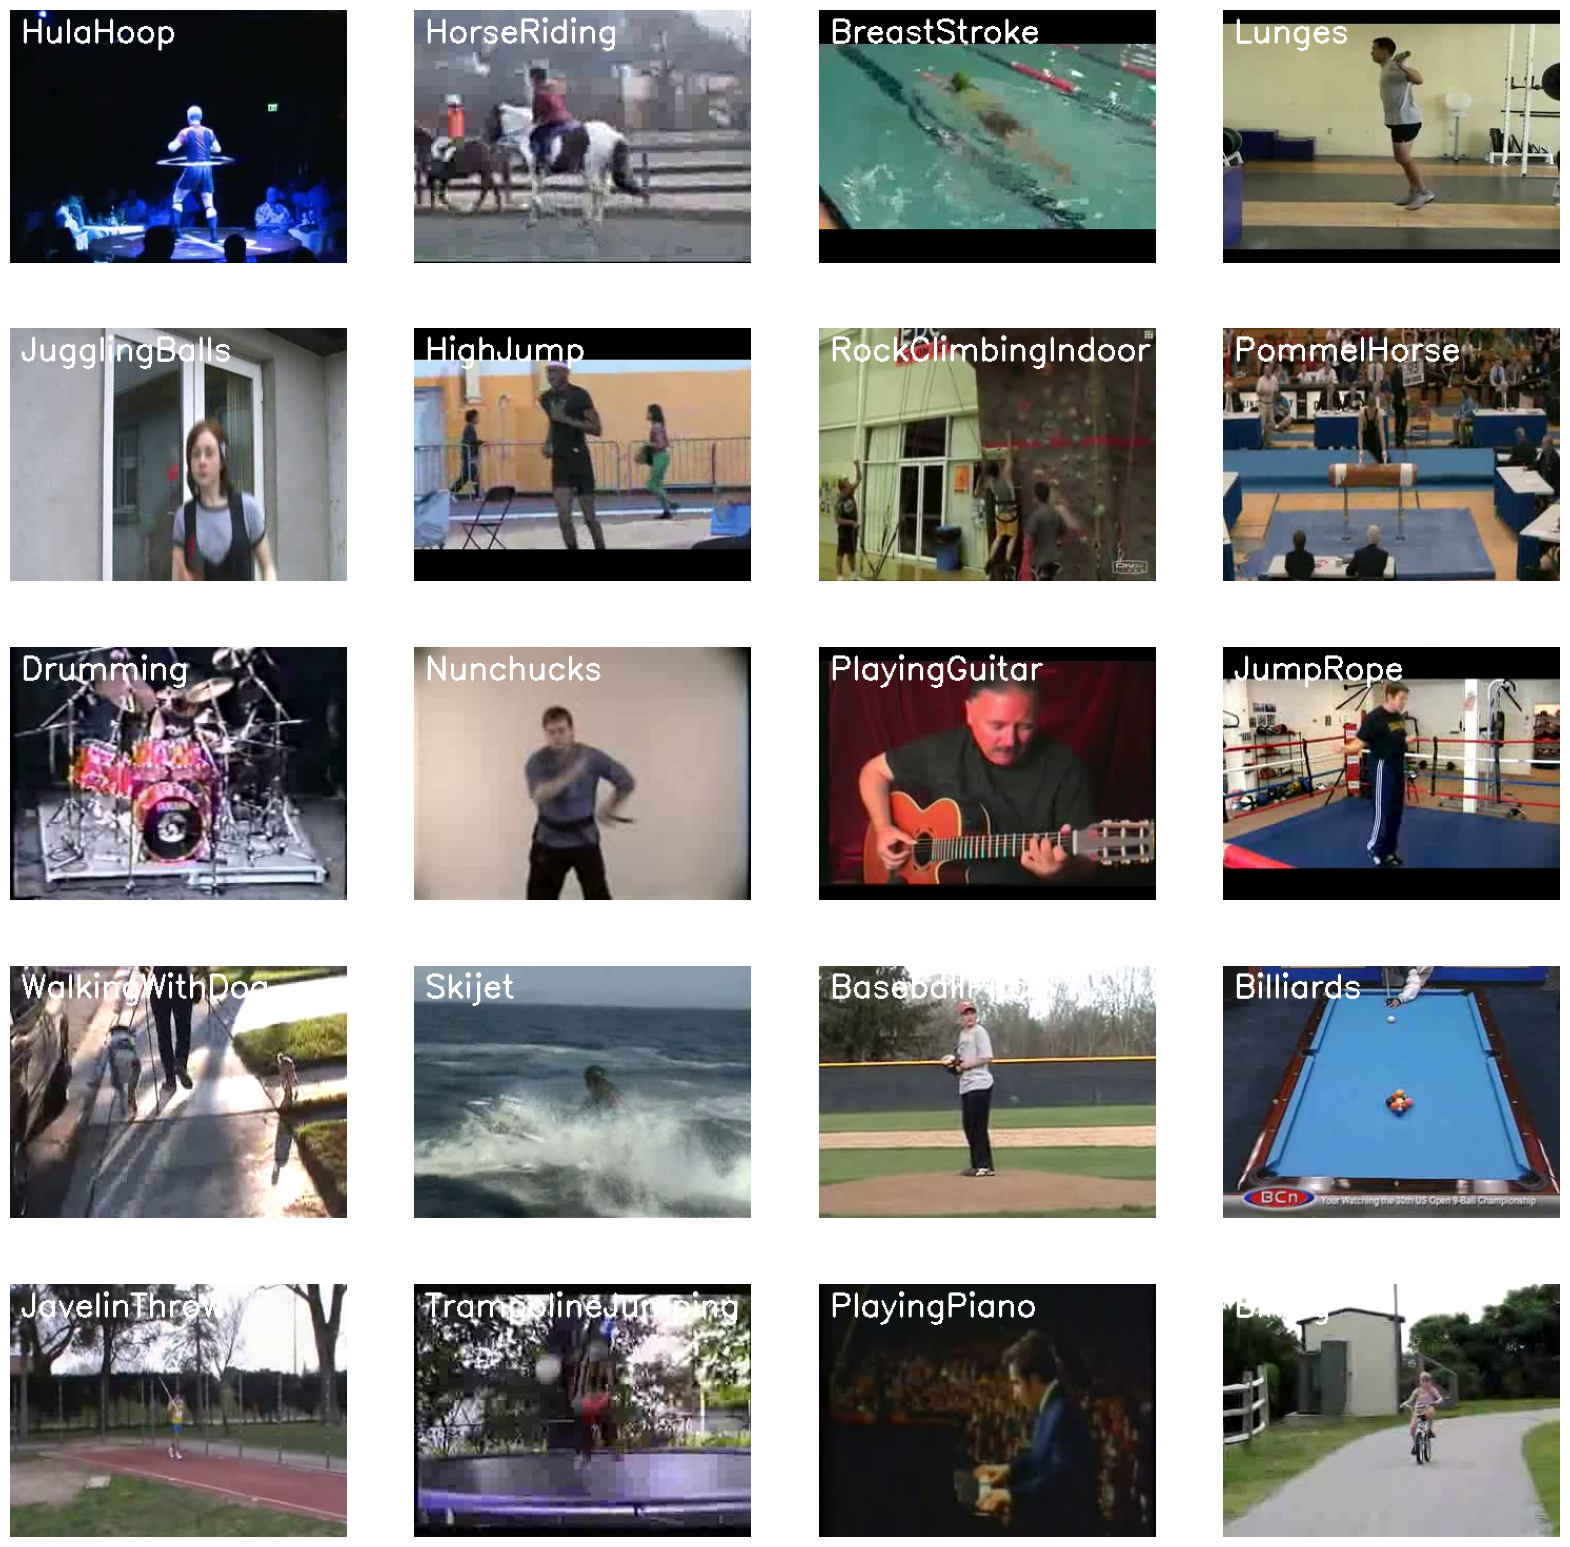

In [5]:
# create a matplotlib figure and specify the figure size
plt.figure(figsize=(20,20))

all_classes_names = os.listdir('UCF50')    # get the names of all classes in dataset
print(len(all_classes_names))              # 50 classes


# generate a list of 20 random values. The values are between 0-50,
# 50 is the total classes
random_range = random.sample(
    range(len(all_classes_names)), 20
)

# iterating over all the generated random values
for counter, random_index in enumerate(random_range, 1):

  # retrieve a classname using the randomly index
  selected_class_name = all_classes_names[random_index]

  # retrieve the filenames of the videos present in the randomly selected class directory
  video_files_names_list = os.listdir(f'UCF50/{selected_class_name}')

  # randomly select a video file from the list retrived from the randomly selected class directory
  selected_video_fname = random.choice(video_files_names_list)

  # initialize the VideoCapture object to read from the video file
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_name}/{selected_video_fname}')

  # reading the first frame of the video
  _, bgr_frame = video_reader.read()

  # release the VideoCapture object
  video_reader.release()

  # convert the frame from BGR to RGB format
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  # write class name on the video frame
  cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

  # display the frame
  plt.subplot(5,4, counter); plt.imshow(rgb_frame); plt.axis('off')

### Step 2: Preprocess the dataset

- read the video files from the dataset and resize the frames of the videos to a fixed height and width.
- divide each pixel by 255 to normalize the data to range [0,1], to reduce the computation. It makes convergence faster while training the network.

In [11]:
# specify the height and width to which each frame will be resized
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# specify the number of frames of a video that will be fed to the model as one sequence
SEQUENCE_LENGTH = 20

# specify directory containing the dataset
DATASET_DIR = 'UCF50'

# specify the list containing the names of classes used for training
# Feel free to choose the classes
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]     # to keep the tutorial short and reduce the training time

**Note:** `IMAGE_EHIGHT`, `IMAGE_WIDTH` and `SEQUENCE_LENGTH` constants can be increased for better results, although increasing the sequence length is only effective to a certain point and increasing the calues will result in the process being more computationally expensive.

#### **Create a function to extract, resize and normalize frames**

The function will accept the path of the video as argument, and the target size. It will output the list of the resized, normalized frames of the video, whose path was inputed.

The function will read the video frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequences length of frames.

In [7]:
def frames_extraction(vpath):
  '''
  This function will extract the required frames from a video after resizing and normalizing them.
  Args:
      vpath: The path of the cideo in the disk, whose frames are to be extracted.
  Returns:
      frames_list: A list containing the resized and normalized frames of the video
  '''

  # to store video frames
  frames_list = []

  # read the video file using VideoCapture object
  video_reader = cv2.VideoCapture(vpath)

  # get the total number of frames in the video
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  # calculate the interval after which frame will be added to the list
  skip_frames_window = max(
      int(video_frames_count/SEQUENCE_LENGTH), 1
  )

  # iterate through video frames
  for frame_counter in range(SEQUENCE_LENGTH):

    # set the frame position of the video
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    # reading that particular frame from the video
    success, frame = video_reader.read()

    # check if video frame is read successfully, otherwise break the loop
    if not success:
      break

    # the code below is if the frame is read correctly
    # resize the frame
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    # normalize the resized frame
    normalized_frame = resized_frame / 255

    frames_list.append(normalized_frame)

  # release the VideoCapture object
  video_reader.release()

  # return the frames list
  return frames_list

#### **Create a function for dataset creation**

We need to perform the operation of frame_extraction for multiple videos in multiple categories, to create our training data.

For this we create another function `create_dataset()` :
- that will iterate through all the specified classes in the `CLASSES_LIST` constant.
- will call the function `frame_extraction()` on every video file of the selected classes
- will return the frames (`features`), class index (`labels`), and video file path (`video_files_paths`)

In [8]:
def create_dataset():
  '''
  This function will extract the data of the selected classes and create the required dataset.
  The required dataset consists of the preprocessed frames from all the categories in one list.
  It is a list of lists of frames.
  A labels list will also be returned which will have class labels of all the list of frames.
  Returns:
      features:             A list containing the extracted frames of the videos. (preprocessed frames)
      labels:               A list containing the indexes of the classes associated with the video.
      video_files_paths:    A list containing the paths of the videos in the disk.
  '''

  # empty lists to store the features, labels, and video file paths
  features = []
  labels = []
  video_files_paths = []

  # iterating over all the classes mentioned in the classes list
  for class_index, class_name in enumerate(CLASSES_LIST):

    # Display the name of the class whose data is being extracted
    print(f'Extracting data of class: {class_name}')

    # get the list of videos present in specific class name directory
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

    # iterate through all the files present in the files list
    for file_name in files_list:

      # get complete video path
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

      # extract frames of the video file
      frames = frames_extraction(video_file_path)

      # check if the extracted frames are equal to the SEQUENCE LENGTH specified above as a constant
      # otherwise, ignore the videos having frames less than the SEQUENCE LENGTH
      if len(frames) == SEQUENCE_LENGTH:

        # Append the data to their respective lists
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  # converting the lists to numpy arrays
  features = np.asarray(features)
  labels = np.asarray(labels)

  # return the frames, class index, and video files paths
  return features, labels, video_files_paths

Now we will utilize the function `create_dataset()` to extract the data of the selected classes and create the required dataset.

In [9]:
# create the dataset
features, labels, video_files_paths = create_dataset()

Extracting data of class: WalkingWithDog
Extracting data of class: TaiChi
Extracting data of class: Swing
Extracting data of class: HorseRace


Now we will convert `labels` i.e. class indexes into one-hot encoded vectors.

In [10]:
# using keras' to_categorical method to convert labels into one-hot encoded vectors
one_hot_encoded_labels = to_categorical(labels)

***Now all the preprocessing steps are done.***

### Step 3: Split the dataset into train and test set

We have the required dataset:
- `features`, a numpy array containing all the extracted and preprocessed frames.
- `one_hot_encoded_labels`, a numpy array containing all class lables in one hot encoded format.

We split our dataset to create the training and testing sets. We will also shuffle the dataset before splitting to avoid any bias. This way we wil get splits representing the overall distribution of the data.

In [11]:
# split the data into train (75%) and test set (25%).
features_train, features_test, labels_train, labels_test = train_test_split(
    features,
    one_hot_encoded_labels,
    test_size = 0.25,
    shuffle = True,
    random_state = seed_constant
)

### Step 4: Implement the NCPS approach

We implement LNCPS approach by combining Convolution and NCP layers in a single model.

The convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to NCP at each time step for temporal sequence modelling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

Read the paper [Neural Circuit Policy for enabling auditable autonomy]() by Ramin Hasani et. al. (Nature Machine Intelligence 2020), to learn about the architecture.

We will also use `TimeDistributed` wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape (no_of_frames, width, height, num_of_channels) if originally the input shape was (width, height, num_of_channels). This is beneficial as it allows to input the whole video into the model in a single shot.

### Step 4.1: Construct the model

To implement NCP, we will use:
- `TimeDistributed` `Conv2D` layers, which will be followed by
- `MaxPooling2D` and `Dropout` layers
- The extracted features from these will be flattened using `Flatten` layer.
- Then will be fed to `LTC` layer.
- The `Dense` layer with softmax activation will then use the output of `LTC` layer to predict the action being performed.

In [2]:
import numpy as np
import os
from tensorflow import keras
from ncps import wirings
from ncps.tf import LTC

In [4]:
wiring = wirings.AutoNCP(28, 4) # 28 neurons, 4 outputs

In [12]:
def create_CNN_NCP_model():
  '''
  This function will construct the required CNN NCP model.
  Returns:
      model: It is the required CNN NCP model
  '''

  # we will use sequential model for model construction
  model = tf.keras.models.Sequential()

  # --------------------BEGIN MODEL ARCHITECTURE-----------------

  model.add(TimeDistributed(
      Conv2D(16, (3,3), padding='same', activation='relu'),
      input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)
  ))
  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  # model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LTC(32))

  model.add(Dense(len(CLASSES_LIST), activation='softmax'))

  #-----------------------END MODEL ARCHITECTURE------------------

  # display model summary
  model.summary()

  # return the constructed model
  return model

We will utilize `create_LRCN_model()` function above to construct the required LRCN model.

In [13]:
# construct the required LRCN model
cnn_ncp_model = create_CNN_NCP_model()

# display the success message
print('Model created successfully!')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 64, 64, 16)    448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 4, 4, 32)     

#### Check model structure

Using the `plot_model()` function, we will check the structure of the constructed LRCN model.

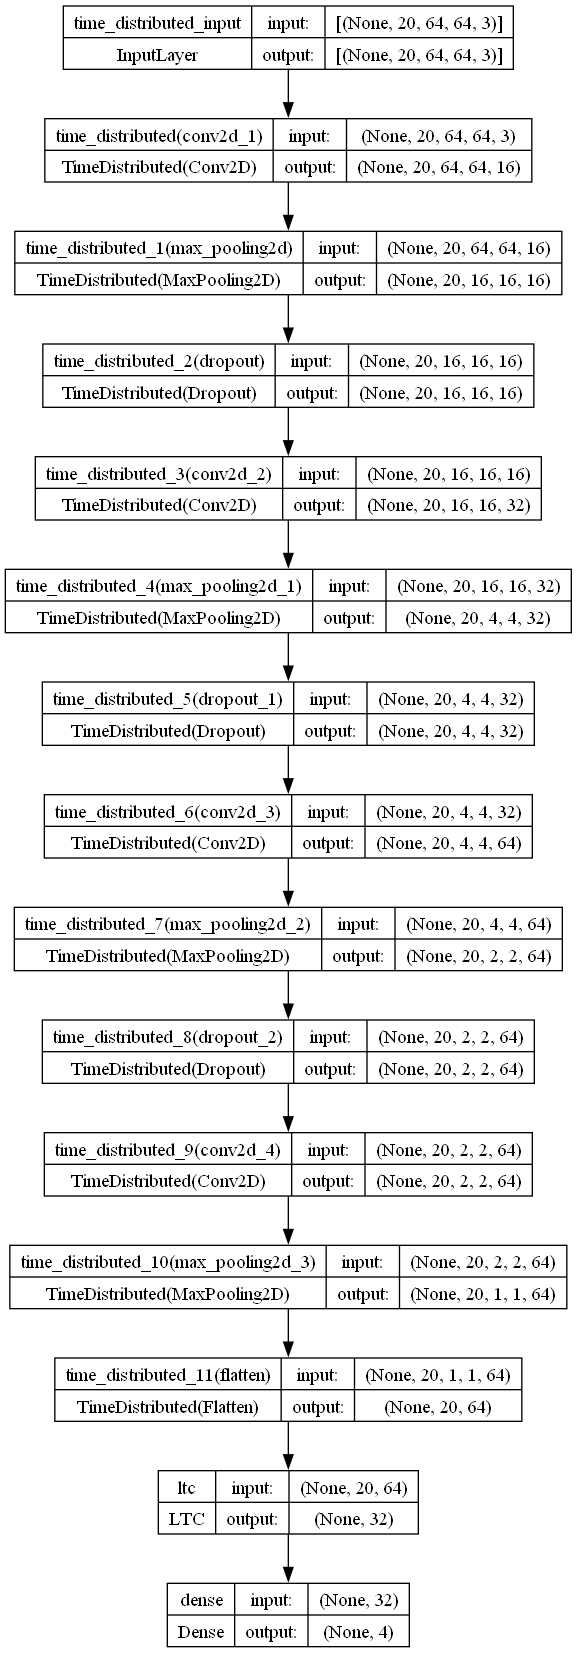

In [15]:
plot_model(cnn_ncp_model, to_file='cnn_ncp_model_structure_plot.png', show_shapes=True, show_layer_names=True)

### Step 4.2: Compile and train the model

After checking the structure we will compile and train the model.

In [24]:
# create an instance of early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=15,
    mode='min',
    restore_best_weights=True
)

# compile the model and specify loss function, optimizer and metrics
lrcn_model.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics = ['accuracy']
)

# start the training
lrcn_model_training_history = lrcn_model.fit(
    x = features_train,
    y = labels_train,
    epochs = 50,
    batch_size = 4,
    shuffle = True,
    validation_split = 0.2,
    callbacks = [early_stopping_callback]
)

Epoch 1/50
73/73 [==============================] - 8s 27ms/step - loss: 1.4129 - accuracy: 0.2945 - val_loss: 1.3728 - val_accuracy: 0.4658
Epoch 2/50
73/73 [==============================] - 1s 13ms/step - loss: 1.3434 - accuracy: 0.3664 - val_loss: 1.3520 - val_accuracy: 0.3014
Epoch 3/50
73/73 [==============================] - 1s 13ms/step - loss: 1.2356 - accuracy: 0.4521 - val_loss: 1.5338 - val_accuracy: 0.2740
Epoch 4/50
73/73 [==============================] - 1s 14ms/step - loss: 1.1411 - accuracy: 0.5411 - val_loss: 1.0937 - val_accuracy: 0.5753
Epoch 5/50
73/73 [==============================] - 1s 14ms/step - loss: 1.0282 - accuracy: 0.5719 - val_loss: 1.0337 - val_accuracy: 0.5616
Epoch 6/50
73/73 [==============================] - 1s 15ms/step - loss: 0.9436 - accuracy: 0.5959 - val_loss: 1.0360 - val_accuracy: 0.5205
Epoch 7/50
73/73 [==============================] - 1s 11ms/step - loss: 0.7775 - accuracy: 0.6644 - val_loss: 0.8072 - val_accuracy: 0.6712
Epoch 8/50
73

#### Evaluating the model
As done for the previous model, we will evaluate the LRCN model on the test set.

In [25]:
# evaluate the trained model
model_evaluation_history = lrcn_model.evaluate(features_test, labels_test)

4/4 [==============================] - 1s 90ms/step - loss: 0.4586 - accuracy: 0.8770


#### Save the model

Now, we will save the model for future uses. For this we will use the same technique we previously used.

In [26]:
# get the loss and accuracy from the model evaluation history
evaluation_loss, evaluation_accuracy = model_evaluation_history

# define the string data-time format
date_time_format = '%Y_%m_%d__%H_%M_%S'

# get the current date and time in a DateTime object
current_date_time_dt = dt.datetime.now()

# convert DateTime object to string, according to the mentioned format
current_date_time_str = dt.datetime.strftime(current_date_time_dt, date_time_format)

# define a useful name for our model to make it easy for us while navigating through multiple saved models
model_file_name = f'lrcn_model__datetime_{current_date_time_str}__loss_{evaluation_loss}__accuracy__{evaluation_accuracy}.h5'



# saving the model
lrcn_model.save(model_file_name)

### Step 5.3: Plot model's loss and accuracy curves

We will use the `plot_metric()` function defined above to plot.

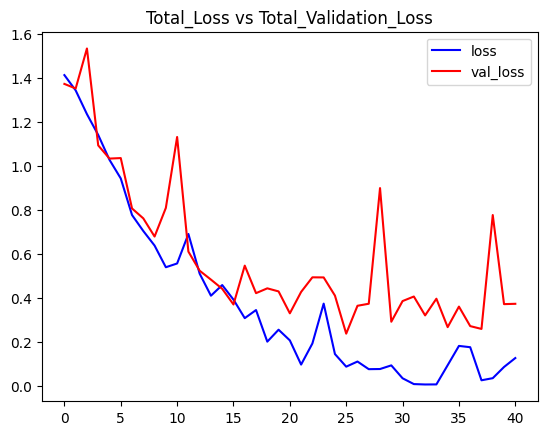

In [27]:
# plot the training and validation loss per epoch
plot_metric(lrcn_model_training_history, 'loss', 'val_loss', 'Total_Loss vs Total_Validation_Loss')

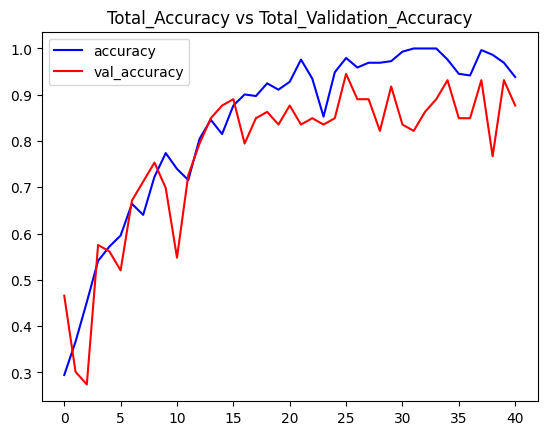

In [28]:
# plot the training and validation accuracy per epoch
plot_metric(lrcn_model_training_history, 'accuracy', 'val_accuracy', 'Total_Accuracy vs Total_Validation_Accuracy')

### Step 5: Test the best performing model on YouTube videos

From the results, we can see that the `LRCN` model performed significantly well fot a small number of classes. Hence, we will use `LRCN` model to test on some youtube videos.

#### Create a function to download youtube videos
We will create a function `download_youtube_videos()` to download the YouTube videos. We will use `pafy` library for this. The library only requires a URL of a video to download it along with its associated metadata like the title of the video.

In [38]:
def download_youtube_videos(youtube_video_url, output_file_directory):
  '''
  This function download ths youtube video whose URL is passed to it as an argument.
  Args:
      youtube_video_url: URL of the video that is required to be downloaded.
      output_directory: The directory path to which the video needs to be stored after downloading.
  Returns:
      title: Title of the downloaded video file
  '''

  # create a video object that contains useful info about the video
  video = pafy.new(youtube_video_url)

  # retieve the title of the video
  title = video.title

  # get the best available quality object for the video
  video_best = video.getbest()

  # construct the output file path
  output_file_path = f'{output_file_directory}/{title}.mp4'

  # download the youtube video at tge best available quality and store it to the constructred path
  video_best.downlaod(filepath = output_file_path, quiet = True)

  # return the video title
  return title

#### Download a test video

We will use the above function `download_youtube_videos()` to download the following file.

In [57]:
# # make output directory if it doesnt exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok=True)

# ## youtube_dl gives error hence not using this part of code
# # downloading the youtube video
# url = 'https://www.youtube.com/watch?v=ds41JD1w-k8'
# video_title = download_youtube_videos(url, test_videos_directory)

# # get the youtube video's path we just downloaded
# input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

# video1 url : https://www.youtube.com/watch?v=ds41JD1w-k8
# video2 url : https://www.youtube.com/watch?v=8u0qjmHIOcE
video_title = 'video2'

# manually getting the path of video file we uploaded
input_video_file_path = f'{test_videos_directory}/video2.mp4'

#### Create a function to perform action recognition of the video

We will create a function `predict_on_video()` that will simply read a video frame by frame from the path passed in as an argument and will perform action recognition on video and save the results.

In [63]:
from collections import deque
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
  '''
  This function will perform video recognition on a video using LRCN model.
  Args:
      video_file_path:  The path of the video stored in the disk on which action recognition is to be performed.
      output_file_path: The path where the output video with the predicted action being performed overlayed will be stored.
      SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
  '''

  # initialize the VideoCapture object to read from the video file
  video_reader = cv2.VideoCapture(video_file_path)

  # get the width and the height of the video.
  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # initialize the VideoWriter object to store the output video in the disk
  video_writer = cv2.VideoWriter(
      output_file_path,
      cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
      video_reader.get(cv2.CAP_PROP_FPS),
      (original_video_width, original_video_height)
  )

  # declare a queue to store video frames
  frames_queue = deque(maxlen = SEQUENCE_LENGTH)

  # initialize a variable to store the predicted action being performed in the video
  predicted_class_name = ''

  # iterate until the video is accessed successfully.
  while video_reader.isOpened():

    # read the frame
    ok, frame = video_reader.read()

    # check if frame is not read properly then break the loop
    if not ok:
      break

    # resize the ddrame to fixed dimension
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    # normalize the resized frame
    normalized_frame  = resized_frame / 255

    # appending the pre-processed frame into the frames list
    frames_queue.append(normalized_frame)

    # check if the number of frames in the queue are equal to the fixed sequence length
    if len(frames_queue) == SEQUENCE_LENGTH:

      # pass normalized frames to the model and get the predicted probabilities.
      predicted_labels_probabilities = lrcn_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

      # get the index of the class with highest probabilities
      predicted_label = np.argmax(predicted_labels_probabilities)

      # get the class name using retrieved index
      predicted_class_name = CLASSES_LIST[predicted_label]

    # write predicted class name on top of frame
    cv2.putText(frame, predicted_class_name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # write the frame into the disk using the VideoWriter object
    video_writer.write(frame)

  # Release the VideoCapture and VideoWriter objects
  video_reader.release()
  video_writer.release()

#### Perform action recognition on the test video

Now we will utilize the function `predict_on_video()` created above to perform action recognition on the test video we uploaded.

We will also display the output video with the predicted action overlayed on it.

In [64]:
# construct output video path
output_video_file_path = f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# perform action recognition on test video
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# display the output video
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 21ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t: 100%|█████████▉| 864/867 [00:02<00:00, 237.95it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file test_videos/video2-Output-SeqLen20.mp4, 360000 bytes wanted but 0 bytes read,at frame 866/867, at time 31.04/31.04 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready __temp__.mp4


#### Create a function to perform a single prediction on videos

We create a function that will perform a single prediction for the complete video. We will extract evenly distributed `N` `(SEQUENCE_LENGTH)` frames from the entire video and pass then to the `lrcn_model`. This approach is really useful when working with videos containing only one activity as it saves unnecessary computations and time in that scenario.

In [71]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
  '''
  This function will perform single action recognition prediction on a video using the lrcn model.
  Args:
      video_file_path: The path of the video stored in the disk on which the action recognition is to be performed.
      SEQUENCE_LENGTH: The fixed number of frames of a video that can be passed to the model as one sequence.
  '''

  # initialize the VideoCapture object to read from the video file.
  video_reader = cv2.VideoCapture(video_file_path)

  # get width and height of the video
  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  # declare the list to store the video frames we will extract
  frames_list = []

  # initialize a variable to store the predicted action being performed in the video
  predicted_class_name = ''

  # get the number of frames in the video
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  # calculate the interval after which frames will be added to the list
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

  # iterate the number of times equal to the fixed length of the sequence
  for frame_counter in range(SEQUENCE_LENGTH):

    # set the current frame position of the video
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    # read a frame
    success, frame = video_reader.read()

    # check if frame is not read properly then break the loop
    if not success:
      break

    # resize the frame to fixed dimentions
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    # normalize the resized frame
    normalized_frame = resized_frame / 255

    # appending the preprocessed frame into the frames list
    frames_list.append(normalized_frame)

  # passing the pre-processed frames to the model and get the predicted probabilities
  predicted_labels_probabilities = lrcn_model.predict(np.expand_dims(frames_list, axis=0))[0]

  # get the index of class with highest probability
  predicted_label = np.argmax(predicted_labels_probabilities)

  # get the class name using the retrieved index
  predicted_class_name = CLASSES_LIST[predicted_label]

  # display the predicted action along with the prediction confidence
  print(f'Action Predicted: {predicted_class_name}',
        f'Confidence: {predicted_labels_probabilities[predicted_label]}',
        sep='\n')

  # release the VideoCapture object
  video_reader.release()

#### Perform single prediction on test video

We utilize the function `predict_single_action()` created above to perform a single prediction on a complete youtube test video that we will upload.

In [72]:
# Uploaded the youtube video, as youtube_dl is giving error
# video3 url: https://www.youtube.com/watch?v=fc3w827kwyA
video_title = 'video3.mp4'

# construct the input youtube video file path
input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

# perform single action prediction on the test video
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

# display the input video
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

ValueError: ignored

The above code did not work due to the following error:

```
ValueError: Exception encountered when calling layer 'time_distributed_3' (type TimeDistributed).
    
    as_list() is not defined on an unknown TensorShape.
    
    Call arguments received by layer 'time_distributed_3' (type TimeDistributed):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • training=False
      • mask=None
```

This can be due to the shape mismatch of the list of model and function. I will fix it later, for now it is not important.